# Estimating Loss with Copia

The data for this first part of the tutorial is sourced from the study by Kestemont & Karsdorp (2019), which marked our initial exploration into the realm of unseen medieval literature using statistical methods. The study addresses a key challenge in historical literature research: the incomplete transmission of sources over centuries, leading to a potential underestimation of the literary diversity of the past. By employing eco-diversity statistical methods on Middle Dutch chivalric epics, the study suggests that previous estimates of text loss might have been too conservative. These methods unveil that up to half, or possibly more, of the original texts may have been lost over time, highlighting the need for quantitative tools to adjust our understanding of historical literary diversity.

## Loading the Data

We will utilize the Pandas library to load our dataset for analysis. The following section provides the necessary code and instructions to successfully load and prepare the data for our exploration using Copia.

In [1]:
import pandas as pd

df = pd.read_csv("../datasets/dum.csv", sep=';')
df.columns = 'work', 'signature'
df.head()

,work,signature
0,Aiol (2),"Breda, Arch. Begijnhof, z.s."
1,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
2,Alexanders geesten,"Gent, UB, 2749,6"
3,Alexanders geesten,"Leiden, UB, Ltk. 1196"
4,Alexanders geesten,"Donaueschingen, Fürstl. Fürstenb. Hofbibl., 173"


The Chao1 estimator formula necessitates the provision of two key parameters from our collection: the number of items occurring once ($f_1$) and the number of items occurring twice ($f_2$). These parameters are pivotal for estimating the unseen diversity in our dataset. Copia comes with a utility function designed to streamline the conversion of our list of works into abundance or incidence data, aligning with the requirements of the different estimators (see the tutorial on loading the data for more details).

In [2]:
from copia.data import to_copia_dataset

ds = to_copia_dataset(
    df, data_type="abundance", input_type="observations", index_column="work")
ds

AbundanceData(S_obs=74, f1=44, f2=13, n=166, counts=array([17, 10, 10,  7,  6,  5,  5,  5,  5,  4,  4,  3,  3,  3,  3,  3,  3,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1]))

## Species Richness

We utilize Copia's `copia.estimators` module to estimate unbiased diversity using one of the available estimators. All estimators can be accessed through a single entry point, the `diversity()` function:

In [3]:
from copia.estimators import diversity

round(diversity(ds, method='chao1'))

148

Copia includes a variety of estimators for your convenience:

In [4]:
for method in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(method, '->', round(diversity(ds, method=method)))

chao1 -> 148
ichao1 -> 166
ace -> 148
jackknife -> 173
egghe_proot -> 165


## Bootstrapped Estimation

The Chao1 estimator provides a lower bound estimate of the unseen species count. However, this estimate itself has an associated range, defined by a lower and upper bound, which represents the confidence interval around the estimate. Two common approaches to obtaining this confidence interval include analytical solutions or bootstrap procedures. In Copia, the bootstrap procedure is implemented to derive these bounds. To enable this feature, set the CI parameter to True when calling the function.

In [5]:
D = diversity(ds, method='chao1', CI=True, n_iter=100, n_jobs=1)
D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.38it/s]


est    148.012975
lci    102.645897
uci    225.651810
Name: 0, dtype: float64

## Rarefaction - Extrapolation

Rarefaction - Extrapolation, or Species Accumulation curves elucidate the relationship between the number of unique species and the increment in sample size (i.e., the number of observations). With Copia, you can compute this relationship effortlessly using the `species_accumulation()` function. Examine the following code snippet for a practical demonstration:

In [6]:
from copia.rarefaction_extrapolation import species_accumulation

accumulation = species_accumulation(ds, max_steps=1000, n_iter=100, step_size=10)
accumulation

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.93it/s]


,est,lci,uci,interpolated
steps,,,,
1,1.000000,1.000000,1.000000,True
11,9.813107,9.437007,10.122258,True
21,17.089954,16.164851,17.961809,True
31,23.373672,21.872014,24.928721,True
41,28.958599,26.894451,31.191359,True
...,...,...,...,...
961,143.697450,103.057990,202.756922,False
971,143.848999,103.084587,203.245463,False
981,143.995227,103.109506,203.721847,False


We can visualize the species accumulation using Copia's `accumulation_curve()` function. The following code snippet demonstrates how to plot the accumulation curve:

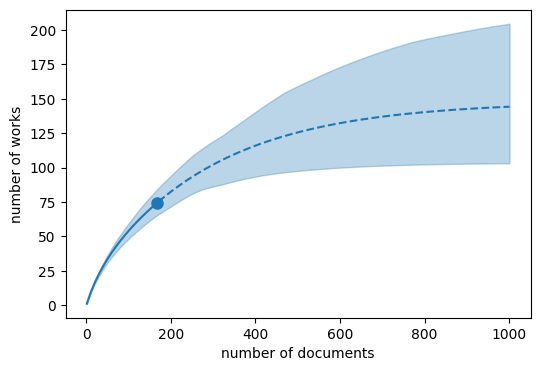

In [9]:
import matplotlib.pyplot as plt
from copia.plot import accumulation_curve

fig, ax = plt.subplots(figsize=(6, 4))

accumulation_curve(
    ds, accumulation, ax=ax, xlabel="number of documents", ylabel="number of works");

In the plotted curve, the blue dot represents the empirical species richness. To its left, the interpolated accumulation of species with increased sampling is depicted (the rarefaction part). On the right, a projection into the future is illustrated, showing the anticipated discovery of new species or works with further document sampling (the extrapolation part). Notably, the curve begins to flatten around 1000 documents, suggesting that beyond this point, no new unseen works are expected to be found according to the estimator.